In [2]:
import requests
import json
import pandas as pd
import time
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import api_key

In [3]:
def fetch_sensors(nwlat, nwlng, selat, selng):
    """Returns all PurpleAir sensors within bounded box with geographic data"""
    headers = {"X-API-KEY": api_key.read}
    params = {"fields": "latitude,longitude"}

    url = f"https://api.purpleair.com/v1/sensors?modified_since=1742022000&nwlat={nwlat}&nwlng={nwlng}&selat={selat}&selng={selng}"
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        sensor_data = pd.DataFrame(response.json()["data"], columns=["sensor_index", "latitude", "longitude"])
        return sensor_data
    else:
        print(response)

In [4]:
geo_data = fetch_sensors(34.334160, -118.655586, 33.694915, -118.128523)
geo_data

,sensor_index,latitude,longitude
0,262161,34.176273,-118.160470
1,262261,34.042206,-118.510950
2,262257,34.191290,-118.164940
3,262343,34.034600,-118.513794
4,262437,34.076538,-118.488320
...,...,...,...
845,261755,34.076340,-118.563200
846,261763,34.199055,-118.148380
847,261767,34.026020,-118.500300
848,261765,34.001890,-118.476490


In [5]:
sensors = geo_data["sensor_index"].values.tolist()

In [6]:
def get_sensor_history(id):
    """Returns pm2.5 yearly average from 2023-2024 for given PurpleAir sensor"""
    headers = {"X-API-KEY": api_key.read}
    params = {"fields": "pm2.5_atm"}
    start = 1678838400  # Mar 15, 2023
    end = 1710460800    # Mar 15, 2024
    average = 525600    # Yearly
    
    url = f"https://api.purpleair.com/v1/sensors/{id}/history?start_timestamp={start}&end_timestamp={end}&average={average}"
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        initial_data = response.json()
        sensor_index = initial_data["sensor_index"]
        data_extract = pd.DataFrame(initial_data["data"])  # data has two values, timestamp and pm2.5
        if not data_extract.empty:
            pm = data_extract[1]  # extract pm2.5
            sensor_data = pd.DataFrame({"sensor_index": sensor_index, "pm2.5_atm": pm})
            return sensor_data
    else:
        print(id)
        print(response)

In [7]:
pm_data = pd.DataFrame()
for sensor in sensors:
    sensor_history = get_sensor_history(sensor)
    if pm_data is None or pm_data.empty:
        pm_data = sensor_history
    else:
        pm_data = pd.concat([pm_data, sensor_history]).reset_index(drop=True)
    time.sleep(1)  # avoid rate limit
pm_data

262161
<Response [429]>


,sensor_index,pm2.5_atm
0,1266,11.0180
1,1517,1675.3925
2,1816,13.0085
3,1976,1970.4205
4,2624,6.0940
...,...,...
452,193197,0.7295
453,198489,14.5720
454,198711,3.6590
455,199615,5.3670


In [42]:
pm_data = pm_data[pm_data["pm2.5_atm"] <= 30]  # drop outliers

In [44]:
combined_data = geo_data.merge(pm_data, on="sensor_index")
combined_data

,sensor_index,latitude,longitude,pm2.5_atm
0,1266,33.863010,-118.388960,11.0180
1,1816,33.763767,-118.145650,13.0085
2,2624,34.024834,-118.429565,6.0940
3,2649,34.294777,-118.579070,10.3895
4,2946,33.992510,-118.472070,7.7825
...,...,...,...,...
423,193197,34.198895,-118.173370,0.7295
424,198489,34.120472,-118.244260,14.5720
425,198711,34.225410,-118.217630,3.6590
426,199615,34.163300,-118.611170,5.3670


In [46]:
street_map = gpd.read_file("lacounty/County_Boundary.shp")

In [48]:
crs = "EPSG:4326"  # designate coordinate system
geometry = [Point(xy) for xy in zip(combined_data["longitude"], combined_data["latitude"])]
geo_df = gpd.GeoDataFrame(combined_data, crs=crs, geometry=geometry)
geo_df.head()

,sensor_index,latitude,longitude,pm2.5_atm,geometry
0,1266,33.863010,-118.388960,11.0180,POINT (-118.39 33.863)
1,1816,33.763767,-118.145650,13.0085,POINT (-118.15 33.764)
2,2624,34.024834,-118.429565,6.0940,POINT (-118.43 34.025)
3,2649,34.294777,-118.579070,10.3895,POINT (-118.58 34.295)
4,2946,33.992510,-118.472070,7.7825,POINT (-118.47 33.993)


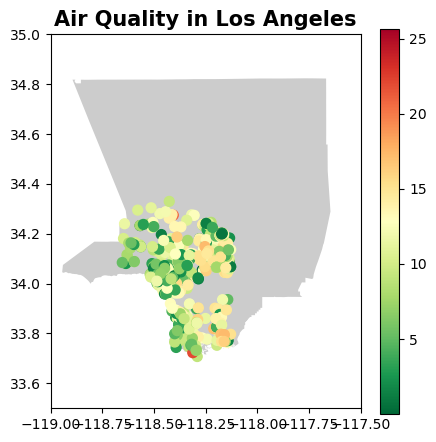

In [54]:
street_map = street_map.to_crs(geo_df.crs)  # match the projection
fig, ax = plt.subplots(figsize=(5,5))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(column="pm2.5_atm", cmap="RdYlGn_r", ax=ax, legend=True, markersize=50)
plt.title("Air Quality in Los Angeles", fontsize=15, fontweight="bold")
plt.xlim(-119, -117.5)
plt.ylim(33.5, 35)
plt.show()